# Implicit Methods for Systems of ODEs

## Linear system

Consider the linear system of ODEs

$$\frac{dX_A}{dt} = -\alpha X_A + \beta X_B$$ 

$$\frac{dX_B}{dt} = \alpha X_A - \beta X_B$$

(system from F. Timmes summer school notes).  We will take:

$$X_A + X_B = 1$$



In matrix form, we can write this as:

$$\frac{d}{dt} \left ( \begin{array}{c}
                                 X_A \\ X_B 
                                \end{array} \right ) 
    = \left ( \begin{array}{rr} 
                           -\alpha & \beta \\
                            \alpha  & -\beta 
                 \end{array}   \right )
 \left ( \begin{array}{c}
                                 X_A \\ X_B 
                                \end{array} \right )$$
                                
or

$$\dot{\bf Y} = {\bf A}{\bf Y}$$ 

with ${\bf Y} = (X_A \,\, X_B)^\intercal$.

This has the solution (for $X_B(0) = 0$):

$$\frac{X_B}{X_A} = \frac{e^{(\alpha + \beta)t} - 1}
    {\tfrac{\beta}{\alpha} e^{(\alpha + \beta)t } + 1}$$
    
and the long-time behavior:

$$X_B/X_A \rightarrow \alpha/\beta$$

The characteristic timescale for change is

$$\tau_\mathrm{ref} = \frac{1}{\alpha + \beta}$$

and we see that

$$d(X_A + X_B)/dt = 0$$
    
We'll use $\alpha = 10^9$ and $\beta = 10^{-5}$ .

In [1]:
alpha = 1.e9
beta = 1.e-5

### Discretization

The backward-Euler discretization of this system is:

$${\bf Y}^{n+1} = {\bf Y}^{n} + \tau {\bf A} {\bf Y}^{n+1}$$

We can write this as a linear system:

$$({\bf I} - \tau {\bf A}) {\bf Y}^{n+1} = {\bf Y}^n$$

This is in the traditional "${\bf A}{\bf x} = {\bf b}$" form of a linear system.


First we need the righthand side function:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def rhs(t, Y):
    """ RHS of the system for explicit methods """
    return np.array([-alpha*Y[0] + beta*Y[1],
                     +alpha*Y[0] - beta*Y[1]])

We'll also provide a function to compute the matrix ${\bf A}$

In [4]:
def ode_mat():
    """ return the matrix A in the linear system of ODEs """
    return np.array([[-alpha,  beta],
                     [+alpha, -beta]], dtype=np.float64)

Now we can implement backward Euler.  We'll use the NumPy linear algebra `solve` method to solve the linear system.

In [5]:
def integrate(Y_0, dt, tmax):
    """ perform a backward-Euler integration """

    XA = Y_0[0]
    XB = Y_0[1]

    tout = [0.0]
    xaout = [XA]
    xbout = [XB]

    t = 0.0
    while t < tmax:

        # create the matrix
        J = np.eye(2) - dt*ode_mat()

        b = np.array([XA, XB])

        # solve the linear system J x = b
        x = np.linalg.solve(J, b)

        XA = x[0]
        XB = x[1]

        t += dt

        tout.append(t)
        xaout.append(XA)
        xbout.append(XB)

    return np.asarray(tout), np.asarray(xaout), np.asarray(xbout)

For comparison, we'll use the analytic solution for the ratio of the species.

In [6]:
def analytic(t):
    return ((np.exp((alpha+beta)*t) - 1.0) /
            ((beta/alpha)*np.exp((alpha+beta)*t) + 1.0))

Finally, a plotting function.  We'll scale the ratio by the asymptotic limit at long times so the ratio should approach 1.

In [7]:
def plot(t, XA, XB, label=None):
    frac_equil = alpha / beta
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    tfine = np.linspace(0, t.max(), 1000)
    
    ax.plot(tfine, analytic(tfine) / frac_equil, label="analytic")
    ax.plot(t, (XB/XA) / frac_equil, label=label)
    
    ax.set_xlabel("t")
    ax.set_ylabel(r"$(X_B/X_A) / (\alpha/\beta)$")
    
    ax.legend(frameon=False)
    return fig

We'll work in terms of the characteristic timescale

In [8]:
tref = 1.0/(alpha + beta)

Let's integrate using a $\tau < \tau_\mathrm{ref}$

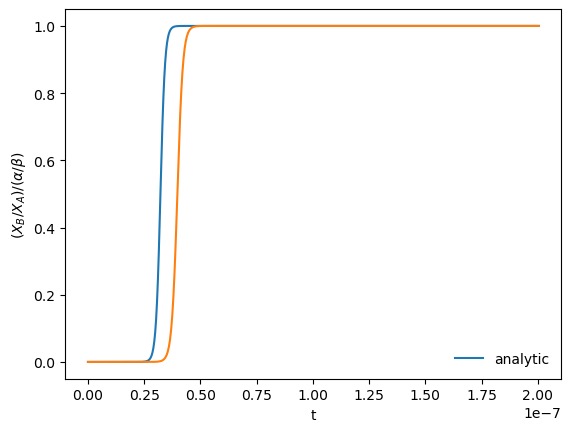

In [9]:
t, XA, XB = integrate([1.0, 0.0], 0.5*tref, 200*tref)
fig = plot(t, XA, XB)

Now let's see what happens with $\tau > \tau_\mathrm{ref}$

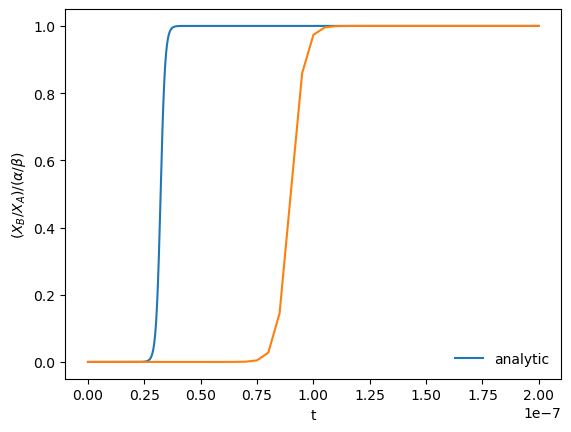

In [10]:
t, XA, XB = integrate([1.0, 0.0], 5*tref, 200*tref)
fig = plot(t, XA, XB)

We see that we don't get the position of the rise correct for either size timestep, but we do get the asymptotic limit correct at the end.

### Runge-Kutta

We can compare the above solution with one from using Runge-Kutta

In [11]:
def rk4_integrate(Y_0, dt, tmax):
    """ 4th-order explicit Runge-Kutta for comparison """

    XA = Y_0[0]
    XB = Y_0[1]

    tout = [0.0]
    xaout = [XA]
    xbout = [XB]

    t = 0.0
    while t < tmax:

        k1 = rhs(t, np.array([XA, XB]))
        k2 = rhs(t+0.5*dt, np.array([XA+0.5*dt*k1[0], XB+0.5*dt*k1[1]]))
        k3 = rhs(t+0.5*dt, np.array([XA+0.5*dt*k2[0], XB+0.5*dt*k2[1]]))
        k4 = rhs(t+dt, np.array([XA+dt*k3[0], XB+dt*k3[1]]))

        XA += (dt/6.0)*(k1[0] + 2.0*k2[0] + 2.0*k3[0] + k4[0])
        XB += (dt/6.0)*(k1[1] + 2.0*k2[1] + 2.0*k3[1] + k4[1])

        t += dt

        tout.append(t)
        xaout.append(XA)
        xbout.append(XB)

    return np.asarray(tout), np.asarray(xaout), np.asarray(xbout)

We'll look at the $\tau > \tau_\mathrm{ref}$ case:

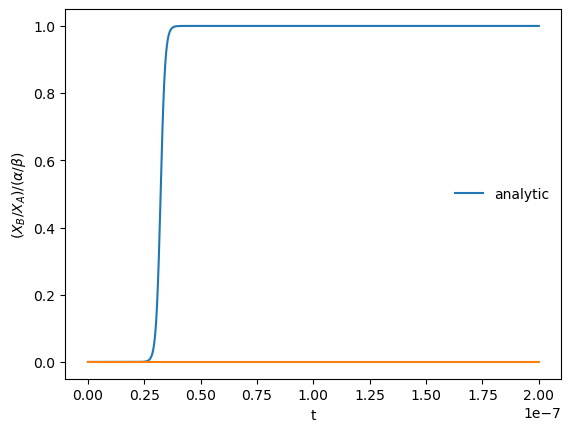

In [12]:
t, XA, XB = rk4_integrate([1.0, 0.0], 5.0*tref, 200*tref)
fig = plot(t, XA, XB)

Now we see that we completely miss the correct long time solution.

### Adaptive Timestepping with RK4

Just to be fair to RK4, let's use the implementation in scipy, which can adapt the timestep as needed.  Let's see how many steps it can solve this in.

Integrators with adaptive stepping change the timestep to ensure that the local error in integration is below a specified tolerance.  We usually specify both a relative, `rtol`, and absolute, `atol`, tolerance and they are combined as:

$$\epsilon_k = {\tt rtol} | y_k | + {\tt atol}$$

where $y_k$ is the $k$-th member of the integration state.

For this problem, we need to make sure that `atol` is really small, or we miss the correct solution.

In [13]:
from scipy.integrate import solve_ivp

In [14]:
sol = solve_ivp(rhs, [0, 200*tref], [1.0, 0.0],
                method="RK45", dense_output=True,
                rtol=1.e-4, atol=1.e-17)

In [15]:
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-22 ...  1.969e-07  2.000e-07]
        y: [[ 1.000e+00  1.000e+00 ...  1.001e-14  1.001e-14]
            [ 0.000e+00  1.000e-13 ...  1.000e+00  1.000e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7fcd4c112480>
 t_events: None
 y_events: None
     nfev: 734
     njev: 0
      nlu: 0


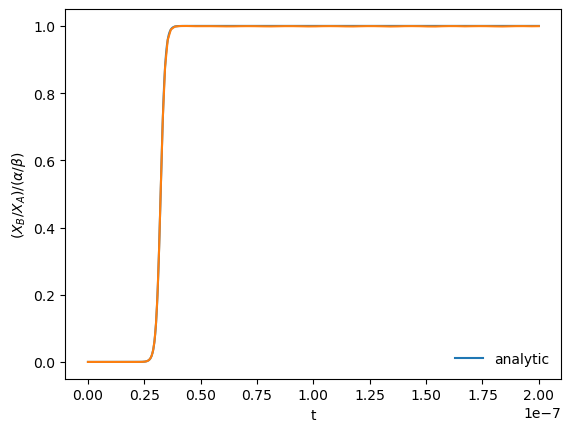

In [16]:
fig = plot(sol.t, sol.y[0,:], sol.y[1,:])

We can see how many steps it took, but looking at the shape of the stored solution:

In [17]:
sol.y.shape

(2, 121)

It took 121 steps to evolve for a timespan of 200 characteristic timescales, so it basically needed to step at / near the characteristic timescale to get a reasonable solution.

This is the difficulty with stiff systems.  Even though the short timescale behavior may be only transient, explicitly methods (generally) need to resolve it in order to stay stable.

### Definition of Stiffness

One common way to define stiffness is to look at the eigenvalues of the Jacobian of the system.  A stiff system has a wide separation between eigenvalues.  For our system, the eigenvalues are:

In [18]:
from sympy import init_session
init_session(use_latex="mathjax")

IPython console for SymPy 1.13.2 (Python 3.12.7-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [19]:
alpha, beta = symbols("alpha beta")

J = Matrix([[-alpha, beta], [alpha, -beta]])
J.eigenvals()

{0: 1, -α - β: 1}

Byrne & Hindmarsh (1986) give a more pragmatic definition of a stiff system:

  > Perhaps the most pragmatic way to determine the stiffness of a system of ODEs
  > is simply to solve it with a non-stiff differential equation package … 
  > Then, record the cost of solving the problem.  By the way, it would be prudent to
  > impose a limit on CPU time or the number of function evaluations.  Similarly, solve 
  > the problem with a stiff ODE package …  Upper bounds on the cost should again be imposed.
  > Now compare the costs of the two solutions over the same time interval.  If the stiff
  > ODE solver was substantially less expensive to use than the non-stiff solver, then
  > the problem was stiff.

This particular system is linear, so there is not too much difference in the performance of an implicit and explicit method (like using the `BDF` method in SciPy).  We'll look at a nonlinear system next.